In [7]:
import h5py
import numpy as np
from scipy import stats
import os

def load_and_compare_ncc_statistically(file_path):
    with h5py.File(file_path, 'r') as file:
        # Load the NCC values and the coordinate data with the correct paths
        ncc_values = file['1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
        X_coords = file['1/EBSD/Data/X'][:]
        Y_coords = file['1/EBSD/Data/Y'][:]

    # Define indices for the first quadrant
    first_quadrant_indices = (X_coords < X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    # Define indices for the second quadrant
    second_quadrant_indices = (X_coords >= X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)

    # Extract NCC values for each quadrant
    first_quadrant_ncc = ncc_values[first_quadrant_indices]
    second_quadrant_ncc = ncc_values[second_quadrant_indices]

    # Calculate statistical measures for each quadrant
    statistics = {
        "first_quadrant": {
            "mean": np.mean(first_quadrant_ncc),
            "median": np.median(first_quadrant_ncc),
            "std_dev": np.std(first_quadrant_ncc),
            "variance": np.var(first_quadrant_ncc),
            "min": np.min(first_quadrant_ncc),
            "max": np.max(first_quadrant_ncc),
            "25th_percentile": np.percentile(first_quadrant_ncc, 25),
            "75th_percentile": np.percentile(first_quadrant_ncc, 75)
        },
        "second_quadrant": {
            "mean": np.mean(second_quadrant_ncc),
            "median": np.median(second_quadrant_ncc),
            "std_dev": np.std(second_quadrant_ncc),
            "variance": np.var(second_quadrant_ncc),
            "min": np.min(second_quadrant_ncc),
            "max": np.max(second_quadrant_ncc),
            "25th_percentile": np.percentile(second_quadrant_ncc, 25),
            "75th_percentile": np.percentile(second_quadrant_ncc, 75)
        }
    }

    # Perform a t-test to check if the means are significantly different
    t_statistic, p_value = stats.ttest_ind(first_quadrant_ncc, second_quadrant_ncc, equal_var=False)
    statistics["t_test"] = {
        "t_statistic": t_statistic,
        "p_value": p_value,
        "significant_difference": p_value < 0.05  # Assuming 0.05 significance level
    }
    
    return statistics

# Example usage
file_path = "/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x16.h5oina"
statistics = load_and_compare_ncc_statistically(file_path)
print("Statistical Comparison Result:", statistics)


Statistical Comparison Result: {'first_quadrant': {'mean': 0.6245915, 'median': 0.7354547, 'std_dev': 0.24239337, 'variance': 0.05875455, 'min': 0.07870632, 'max': 0.8045526, '25th_percentile': 0.6838549375534058, '75th_percentile': 0.7624737620353699}, 'second_quadrant': {'mean': 0.35779014, 'median': 0.373017, 'std_dev': 0.058735326, 'variance': 0.0034498386, 'min': 0.06385708, 'max': 0.4672669, '25th_percentile': 0.32521068304777145, '75th_percentile': 0.40067972987890244}, 't_test': {'t_statistic': 90.4093269102216, 'p_value': 0.0, 'significant_difference': True}}


Error processing pair (/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test saturated 49 pps(1).h5oina, /Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed saturated 49 pps(1).h5oina): 'Unable to open object (component not found)'
Error processing pair (/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x16.h5oina, /Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x16.h5oina): 'Unable to open object (component not found)'
Error processing pair (/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x32(1).h5oina, /Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x32(1).h5oina): 'Unable to open object (component not found)'
Error processing pair (/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x64.

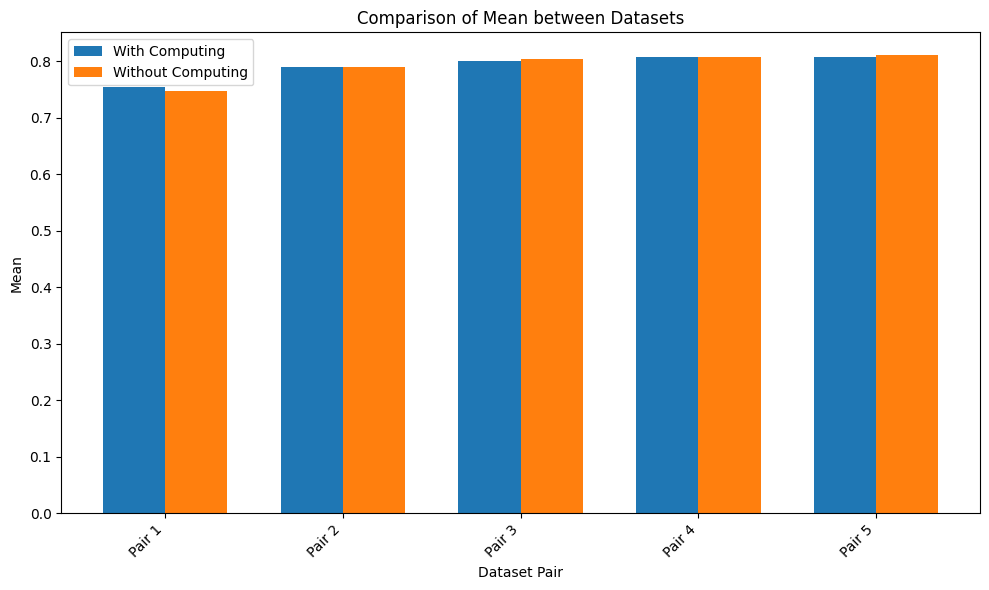

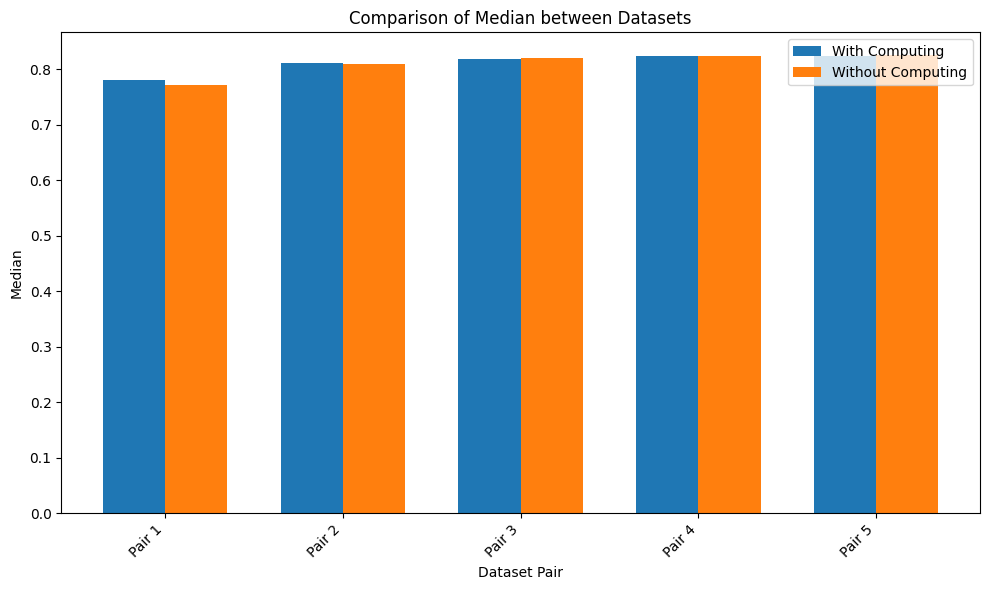

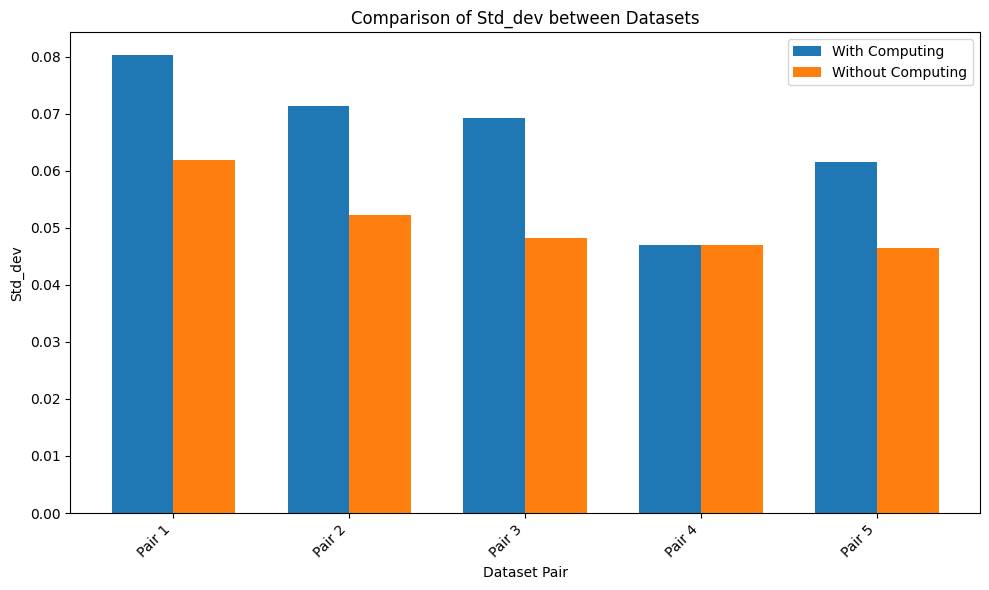

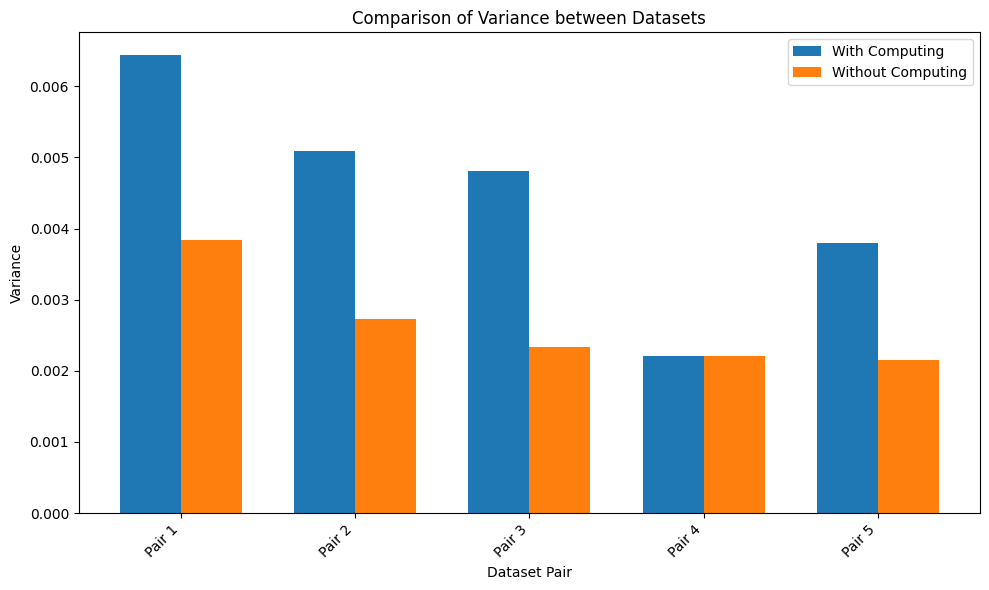

In [ ]:
import h5py
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import gaussian_kde
import os

def clean_ncc_values(ncc_values):
    """Replace extreme outliers and ensure values stay within the range [-1, 1]."""
    # Calculate the mean of valid values in the range [-1, 1]
    valid_mean = np.mean(ncc_values[(ncc_values >= -1) & (ncc_values <= 1)])
    
    # Replace values outside the range [-1, 1] with the calculated mean
    ncc_values = np.where(ncc_values < -1, valid_mean, ncc_values)
    ncc_values = np.where(ncc_values > 1, valid_mean, ncc_values)
    
    return ncc_values


def load_ncc_data(file_path):
    """Load and clean NCC values, X coordinates, and Y coordinates from the specified HDF5 file."""
    with h5py.File(file_path, 'r') as file:
        ncc_values = file['1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
        X_coords = file['1/EBSD/Data/X'][:]
        Y_coords = file['1/EBSD/Data/Y'][:]
    
    # Clean the NCC values by handling specific outliers and clipping to the range [0, 1]
    ncc_values = clean_ncc_values(ncc_values)
    
    return ncc_values, X_coords, Y_coords

def compare_ncc_statistics_between_datasets(ncc_values_1, ncc_values_2, file_path_1, file_path_2):
    """Compute statistical comparisons of NCC values between two datasets."""
    # Calculate statistics for each dataset
    statistics = {
        "dataset_1_mean": np.mean(ncc_values_1),
        "dataset_1_median": np.median(ncc_values_1),
        "dataset_1_std_dev": np.std(ncc_values_1),
        "dataset_1_variance": np.var(ncc_values_1),
        "dataset_1_min": np.min(ncc_values_1),
        "dataset_1_max": np.max(ncc_values_1),
        "dataset_2_mean": np.mean(ncc_values_2),
        "dataset_2_median": np.median(ncc_values_2),
        "dataset_2_std_dev": np.std(ncc_values_2),
        "dataset_2_variance": np.var(ncc_values_2),
        "dataset_2_min": np.min(ncc_values_2),
        "dataset_2_max": np.max(ncc_values_2)
    }

    # Perform a t-test between the two datasets
    t_statistic, p_value = stats.ttest_ind(ncc_values_1, ncc_values_2, equal_var=False)
    statistics["t_test_statistic"] = t_statistic
    statistics["t_test_p_value"] = p_value
    statistics["significant_difference"] = p_value < 0.05  # Assuming 0.05 significance level
    
    # Add file paths for reference
    statistics["file_path_1"] = file_path_1
    statistics["file_path_2"] = file_path_2
    
    return statistics

def load_statistics_between_datasets(file_paths_1, file_paths_2):
    """Process pairs of datasets and return a DataFrame with statistical comparisons."""
    results = []
    
    for file_path_1, file_path_2 in zip(file_paths_1, file_paths_2):
        try:
            # Load NCC values for both datasets
            ncc_values_1, _, _ = load_ncc_data(file_path_1)
            ncc_values_2, _, _ = load_ncc_data(file_path_2)
            
            # Compute statistics between the two datasets
            stats = compare_ncc_statistics_between_datasets(
                ncc_values_1, ncc_values_2, file_path_1, file_path_2
            )
            results.append(stats)
        except Exception as e:
            print(f"Error processing pair ({file_path_1}, {file_path_2}): {e}")
    
    # Create a DataFrame from the results list
    df = pd.DataFrame(results)
    return df

import matplotlib.pyplot as plt

def visualize_statistics_between_datasets(statistics_df):
    """Visualize the statistical comparisons between two datasets."""
    # Define the statistical factors to compare
    factors = ["mean", "median", "std_dev", "variance"]
    
    # Set up the plots for each factor
    for factor in factors:
        dataset_1_values = statistics_df[f"dataset_1_{factor}"]
        dataset_2_values = statistics_df[f"dataset_2_{factor}"]
        file_paths_1 = statistics_df["file_path_1"]
        file_paths_2 = statistics_df["file_path_2"]
        
        # Plot the bar chart for the current factor
        fig, ax = plt.subplots(figsize=(10, 6))
        index = range(len(file_paths_1))
        bar_width = 0.35
        
        # Bars for dataset 1
        ax.bar(index, dataset_1_values, bar_width, label='With Computing')
        
        # Bars for dataset 2, offset by bar_width
        ax.bar([i + bar_width for i in index], dataset_2_values, bar_width, label='Without Computing')
        
        # Configure plot labels and title
        ax.set_xlabel("Dataset Pair")
        ax.set_ylabel(factor.capitalize())
        ax.set_title(f"Comparison of {factor.capitalize()} between Datasets")
        ax.set_xticks([i + bar_width / 2 for i in index])
        ax.set_xticklabels([f"Pair {i+1}" for i in index], rotation=45, ha="right")
        ax.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage
# This assumes statistics_df is the DataFrame returned from load_statistics_for_multiple_datasets()

def clean_file_paths(statistics_df, prefix_to_remove):
    """Remove the specified prefix from each file path in the DataFrame."""
    statistics_df["file_path"] = statistics_df["file_path"].str.replace(prefix_to_remove, "", regex=False)
    return statistics_df


# Example usage
file_paths_with_computing = [
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 4 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 9 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 16 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 25 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test saturated 49 pps(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x16.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x32(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x64.h5oina',
]

file_paths_without_computing = [
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 1 frame.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 4 frames.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 9 frames.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 16 frames.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 25 frames.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed saturated 49 pps(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x16.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x32(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 speed test speed x64.h5oina',
]



def plot_combined_histogram_with_kde_and_title(ncc_values, X_coords, Y_coords, file_path):
    """Plot a combined histogram with KDE lines and a title for each dataset."""
    # Define indices for the first and second quadrants
    first_quadrant_indices = (X_coords < X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    second_quadrant_indices = (X_coords >= X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    
    # Extract NCC values for each quadrant
    first_quadrant_ncc = ncc_values[first_quadrant_indices]
    second_quadrant_ncc = ncc_values[second_quadrant_indices]
    
    # Generate a shortened title from the file name
    short_title = os.path.basename(file_path).replace(".h5oina", "")
    
    # Plot the combined histogram
    plt.figure(figsize=(10, 6))
    plt.hist(first_quadrant_ncc, bins=30, alpha=0.6, label="First Quadrant", color='blue', edgecolor='black', density=True)
    plt.hist(second_quadrant_ncc, bins=30, alpha=0.6, label="Second Quadrant", color='orange', edgecolor='black', density=True)
    
    # Add KDE lines for each quadrant
    kde_first = gaussian_kde(first_quadrant_ncc)
    kde_second = gaussian_kde(second_quadrant_ncc)
    
    # Create an x-axis range for the KDE lines
    x_values = np.linspace(0, 1, 1000)  # Adjust based on NCC range
    
    plt.plot(x_values, kde_first(x_values), color='blue', linestyle='-', linewidth=2, label='First Quadrant KDE')
    plt.plot(x_values, kde_second(x_values), color='orange', linestyle='-', linewidth=2, label='Second Quadrant KDE')
    
    # Customize the plot
    plt.title(f"{short_title}")
    plt.xlabel("NCC Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_combined_histograms_with_titles(file_paths):
    """Generate and display combined histograms with KDE lines and titles for each dataset."""
    for file_path in file_paths:
        try:
            ncc_values, X_coords, Y_coords = load_ncc_data(file_path)
            plot_combined_histogram_with_kde_and_title(ncc_values, X_coords, Y_coords, file_path)
        except Exception as e:
            print(f"Error processing {file_path} for combined histogram with title visualization: {e}")




statistics_df = load_statistics_between_datasets(file_paths_with_computing, file_paths_without_computing)

# Visualize the results
print(statistics_df.to_string())



prefix_to_remove = "/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1"

# Clean up the file paths in the DataFrame
# statistics_df = clean_file_paths(statistics_df, prefix_to_remove)

visualize_statistics_between_datasets(statistics_df)

# visualize_combined_histograms_with_titles(file_paths)




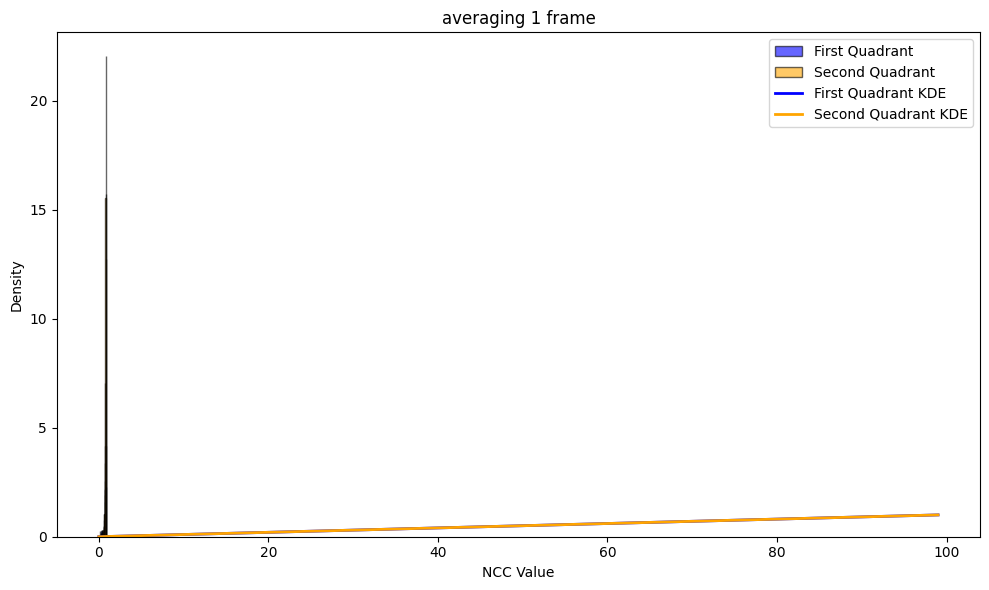

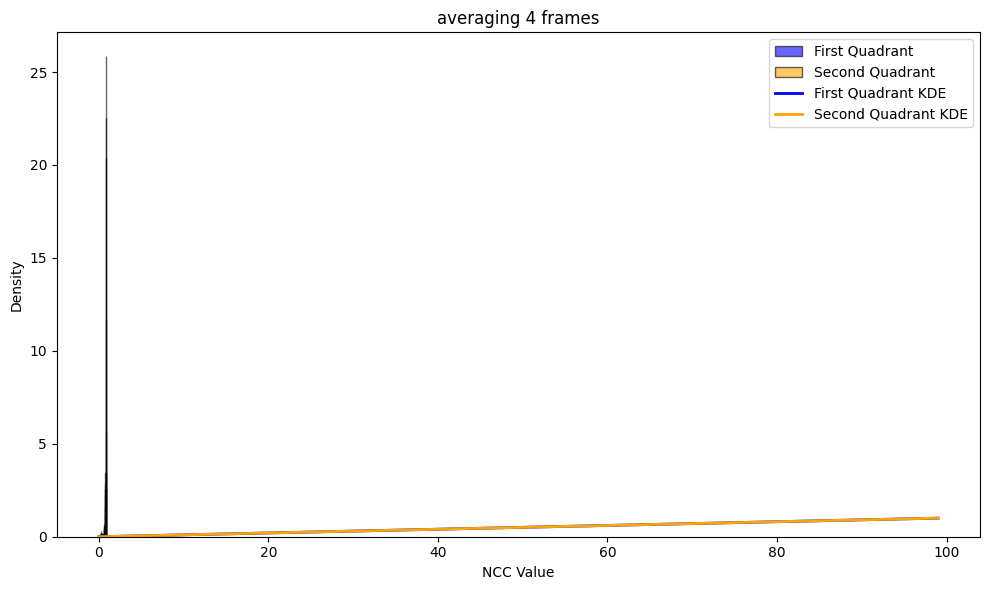

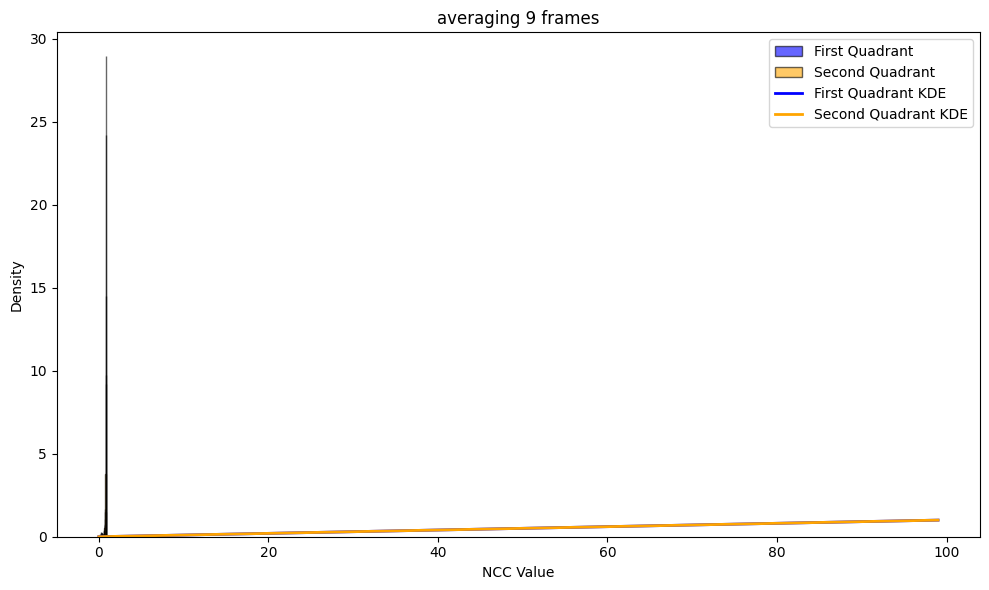

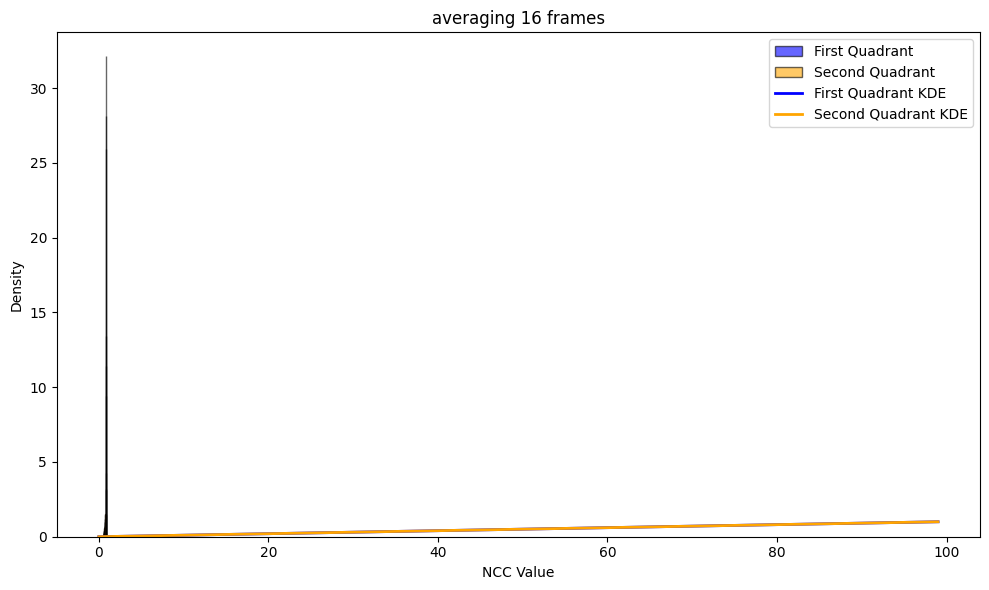

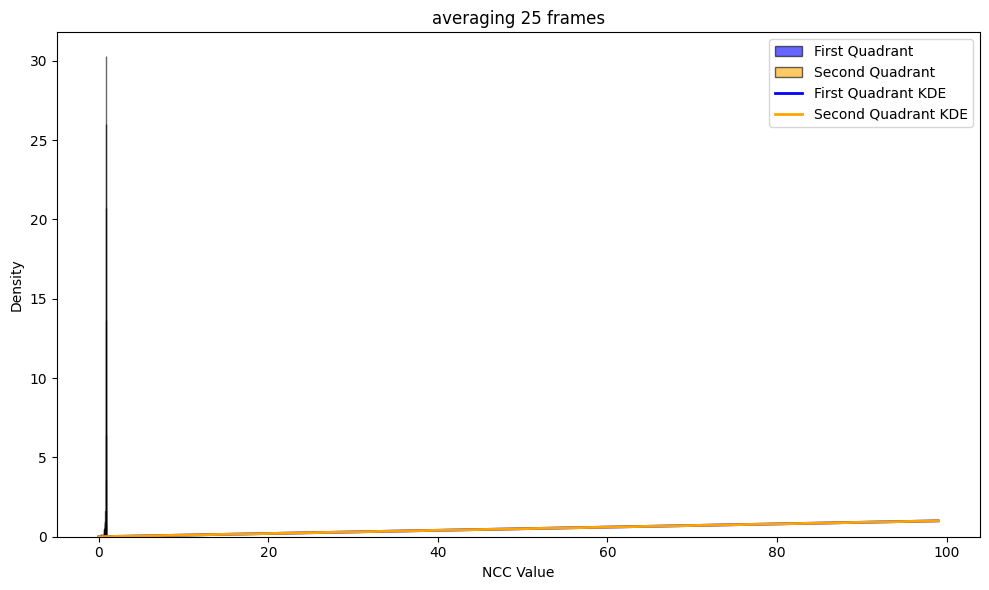

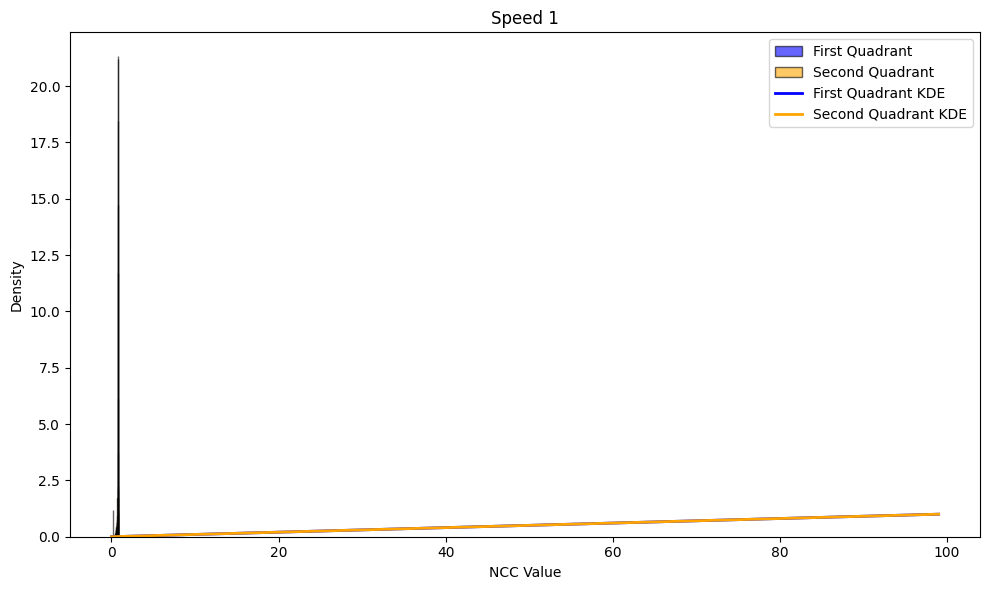

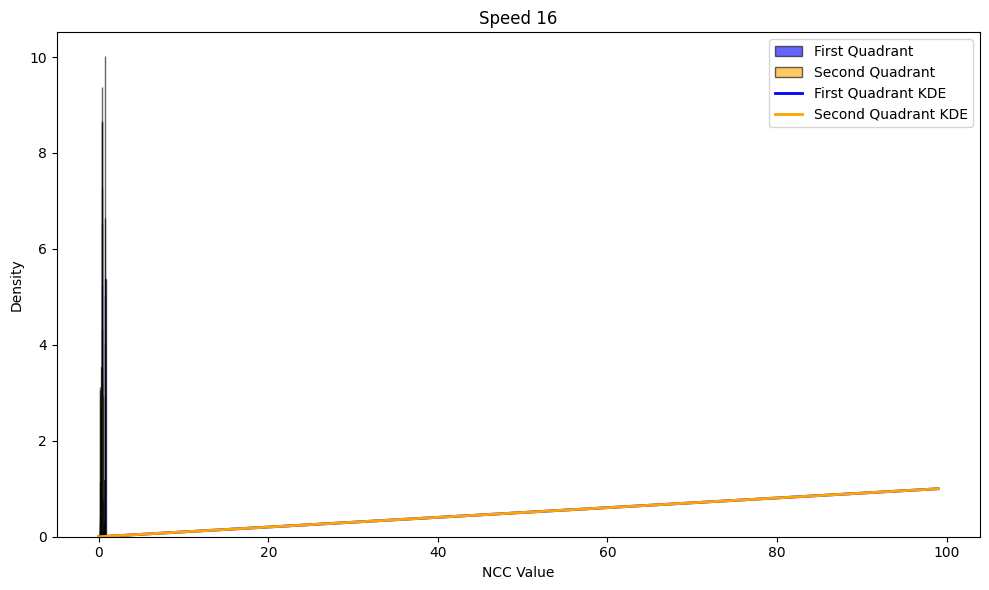

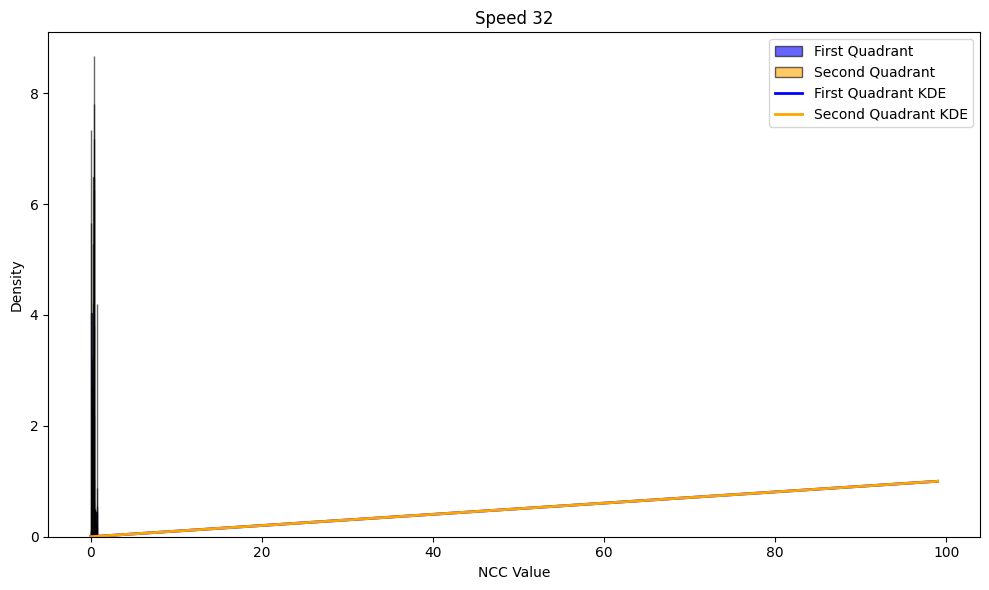

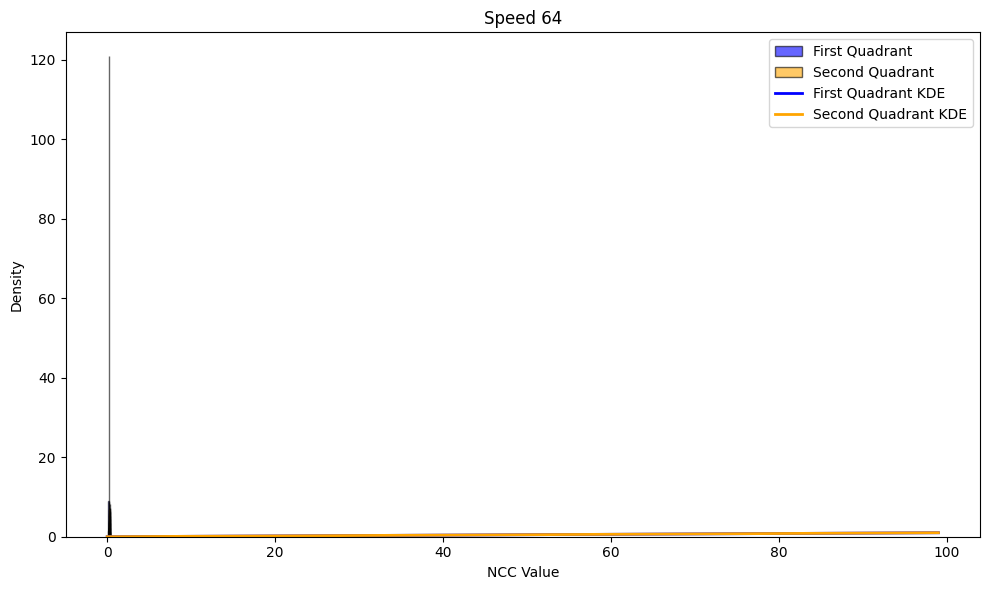

In [4]:
import h5py
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import gaussian_kde
import os
import matplotlib.pyplot as plt

def clean_ncc_values(ncc_values):
    """Replace extreme outliers and ensure values stay within the range [-1, 1]."""
    valid_mean = np.mean(ncc_values[(ncc_values >= -1) & (ncc_values <= 1)])
    ncc_values = np.where(ncc_values < -1, valid_mean, ncc_values)
    ncc_values = np.where(ncc_values > 1, valid_mean, ncc_values)
    return ncc_values

def load_ncc_data(file_path):
    """Load and clean NCC values, X coordinates, and Y coordinates from the specified HDF5 file."""
    with h5py.File(file_path, 'r') as file:
        ncc_values = file['1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
        X_coords = file['1/EBSD/Data/X'][:]
        Y_coords = file['1/EBSD/Data/Y'][:]
    ncc_values = clean_ncc_values(ncc_values)
    return ncc_values, X_coords, Y_coords

def compare_ncc_statistics(ncc_values, X_coords, Y_coords):
    """Compute statistical comparisons of NCC values between the first and second quadrants."""
    first_quadrant_indices = (X_coords < X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    second_quadrant_indices = (X_coords >= X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    first_quadrant_ncc = ncc_values[first_quadrant_indices]
    second_quadrant_ncc = ncc_values[second_quadrant_indices]

    statistics = {
        "first_quadrant_mean": np.mean(first_quadrant_ncc),
        "first_quadrant_median": np.median(first_quadrant_ncc),
        "first_quadrant_std_dev": np.std(first_quadrant_ncc),
        "first_quadrant_variance": np.var(first_quadrant_ncc),
        "first_quadrant_min": np.min(first_quadrant_ncc),
        "first_quadrant_max": np.max(first_quadrant_ncc),
        "second_quadrant_mean": np.mean(second_quadrant_ncc),
        "second_quadrant_median": np.median(second_quadrant_ncc),
        "second_quadrant_std_dev": np.std(second_quadrant_ncc),
        "second_quadrant_variance": np.var(second_quadrant_ncc),
        "second_quadrant_min": np.min(second_quadrant_ncc),
        "second_quadrant_max": np.max(second_quadrant_ncc)
    }

    t_statistic, p_value = stats.ttest_ind(first_quadrant_ncc, second_quadrant_ncc, equal_var=False)
    statistics["t_test_statistic"] = t_statistic
    statistics["t_test_p_value"] = p_value
    statistics["significant_difference"] = p_value < 0.05
    
    return statistics

def plot_combined_histogram_with_kde_and_title(ncc_values, X_coords, Y_coords, histogram_name="Histogram"):
    """Plot a combined histogram with KDE lines and a custom title."""
    first_quadrant_indices = (X_coords < X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    second_quadrant_indices = (X_coords >= X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    first_quadrant_ncc = ncc_values[first_quadrant_indices]
    second_quadrant_ncc = ncc_values[second_quadrant_indices]
    
    plt.figure(figsize=(10, 6))
    plt.hist(first_quadrant_ncc, bins=30, alpha=0.6, label="First Quadrant", color='blue', edgecolor='black', density=True)
    plt.hist(second_quadrant_ncc, bins=30, alpha=0.6, label="Second Quadrant", color='orange', edgecolor='black', density=True)
    
    kde_first = gaussian_kde(first_quadrant_ncc)
    kde_second = gaussian_kde(second_quadrant_ncc)
    x_values = np.linspace(0, 1, 100)
    
    plt.plot(x_values, color='blue', linestyle='-', linewidth=2, label='First Quadrant KDE')
    plt.plot(x_values, color='orange', linestyle='-', linewidth=2, label='Second Quadrant KDE')
    
    plt.title(histogram_name)
    plt.xlabel("NCC Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_combined_histograms_with_custom_titles(file_paths, custom_titles):
    """Generate combined histograms with custom titles."""
    for file_path, custom_title in zip(file_paths, custom_titles):
        try:
            ncc_values, X_coords, Y_coords = load_ncc_data(file_path)
            plot_combined_histogram_with_kde_and_title(ncc_values, X_coords, Y_coords, histogram_name=custom_title)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
# Example usage
file_paths = [
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 4 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 9 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 16 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 25 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test saturated 49 pps(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x16.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x32(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x64.h5oina',
]

custom_titles = [
    'averaging 1 frame',
    'averaging 4 frames',
    'averaging 9 frames',
    'averaging 16 frames',
    'averaging 25 frames',
    'Speed 1',
    'Speed 16',
    'Speed 32',
    'Speed 64'
]

# statistics_df = load_statistics_for_multiple_datasets(file_paths)

# prefix_to_remove = "/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1"
# statistics_df = clean_file_paths(statistics_df, prefix_to_remove)

# print(statistics_df.to_string())
# visualize_quadrant_statistics(statistics_df)
visualize_combined_histograms_with_custom_titles(file_paths, custom_titles)


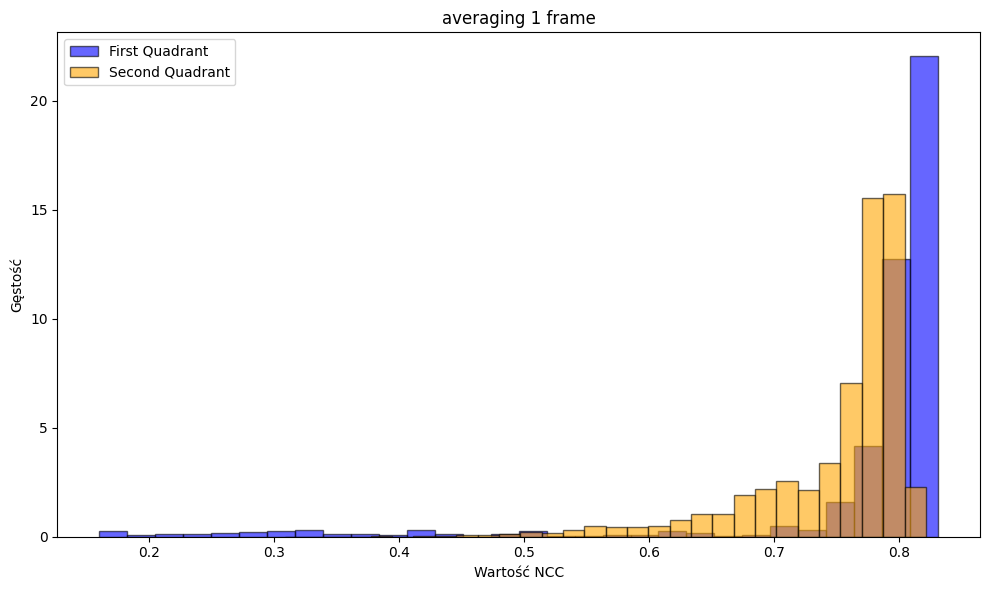

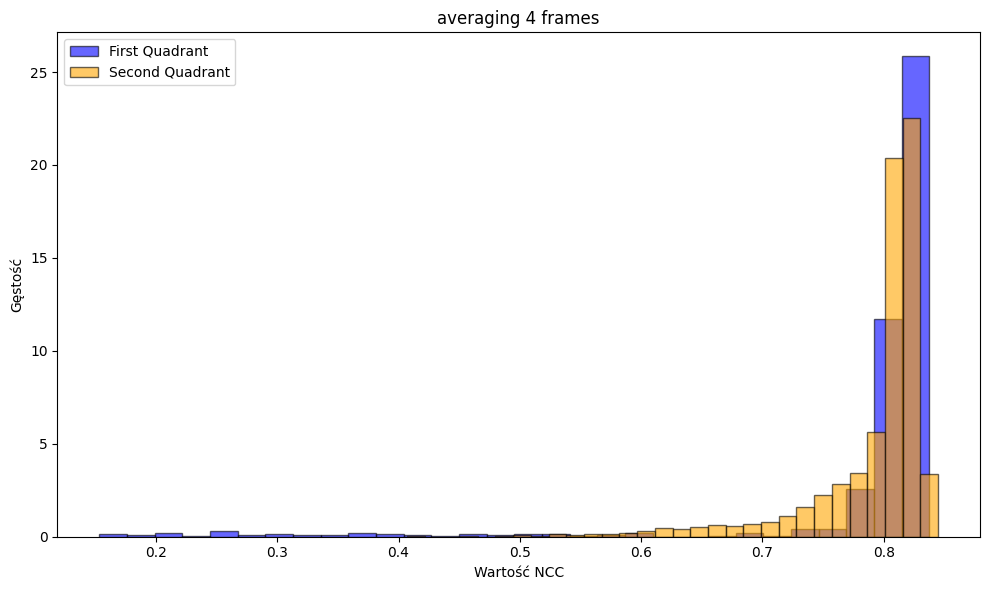

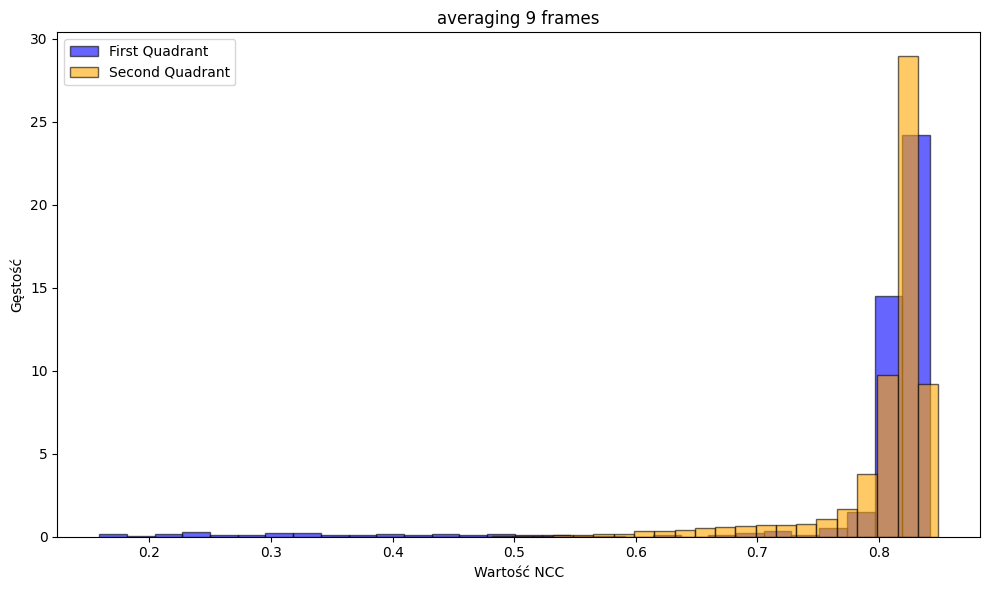

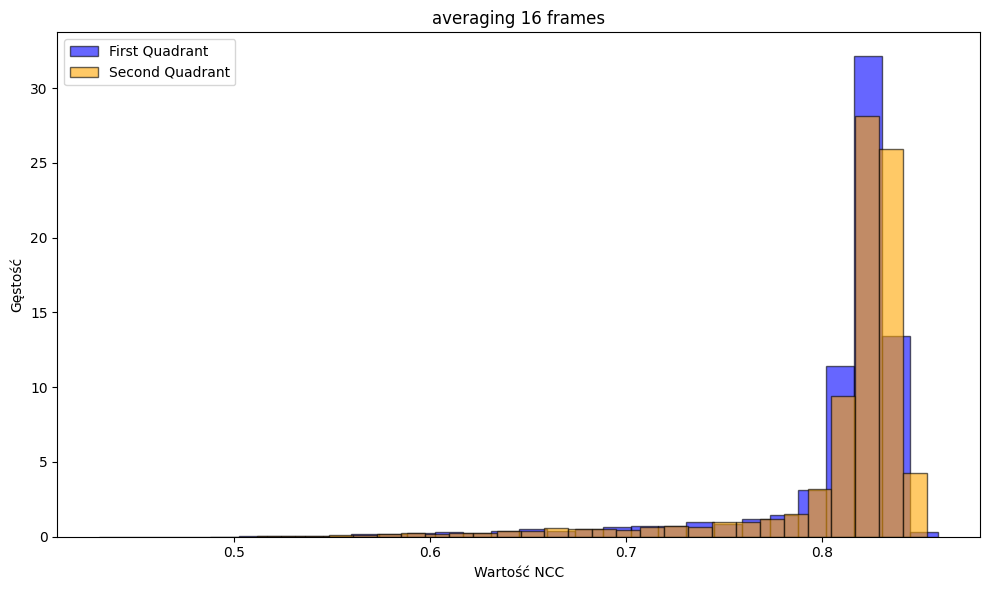

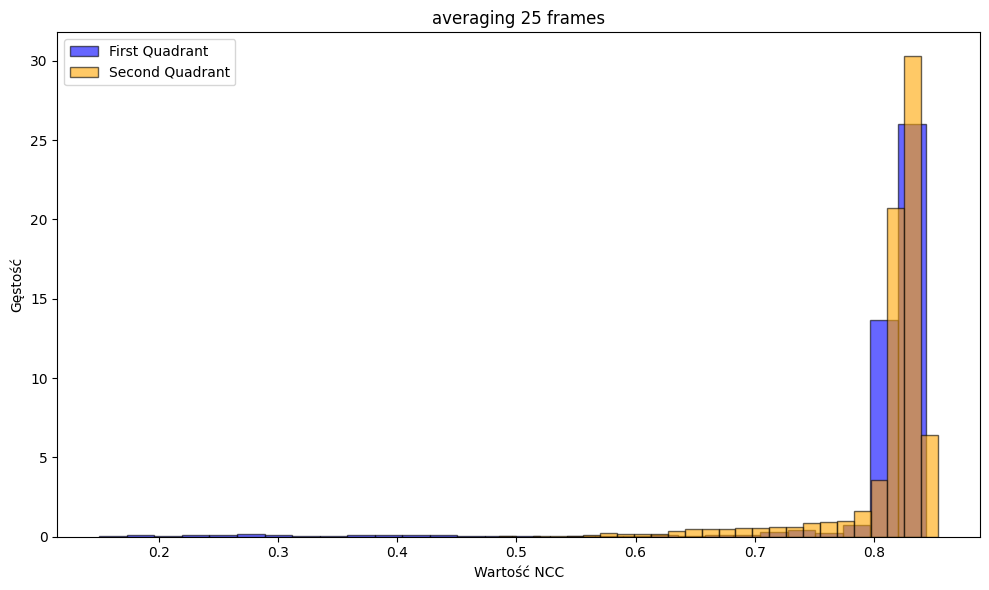

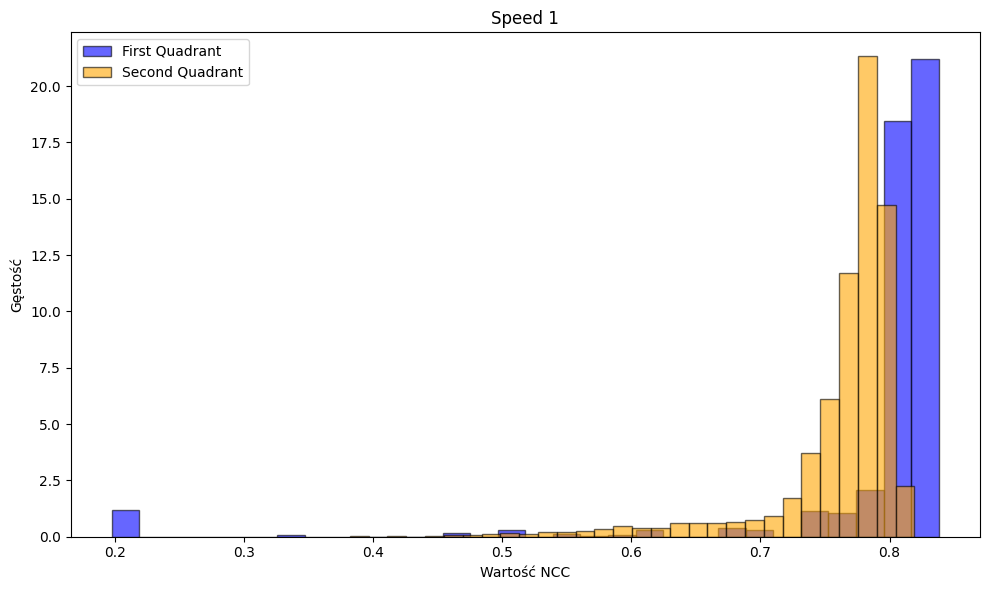

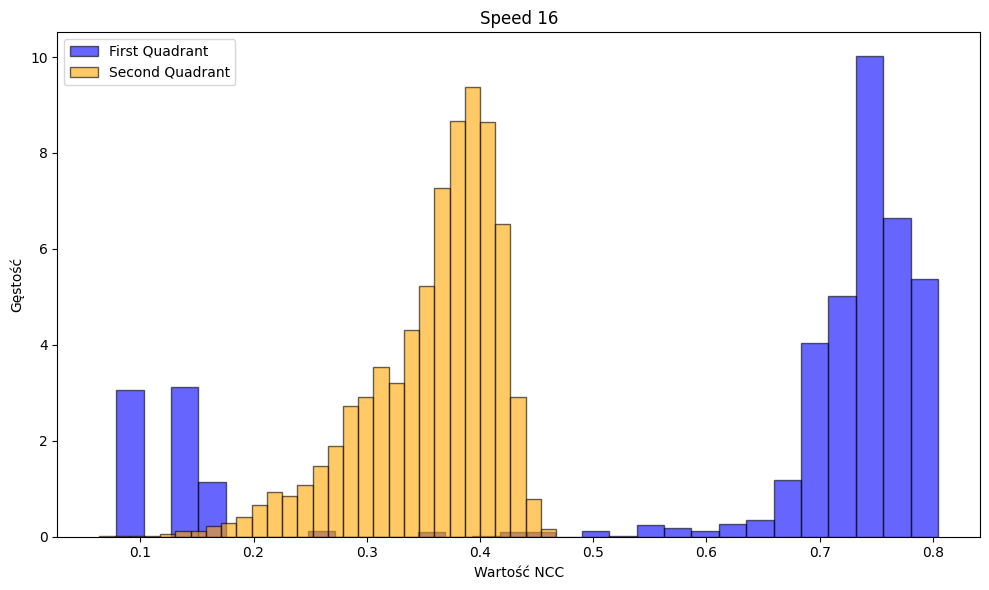

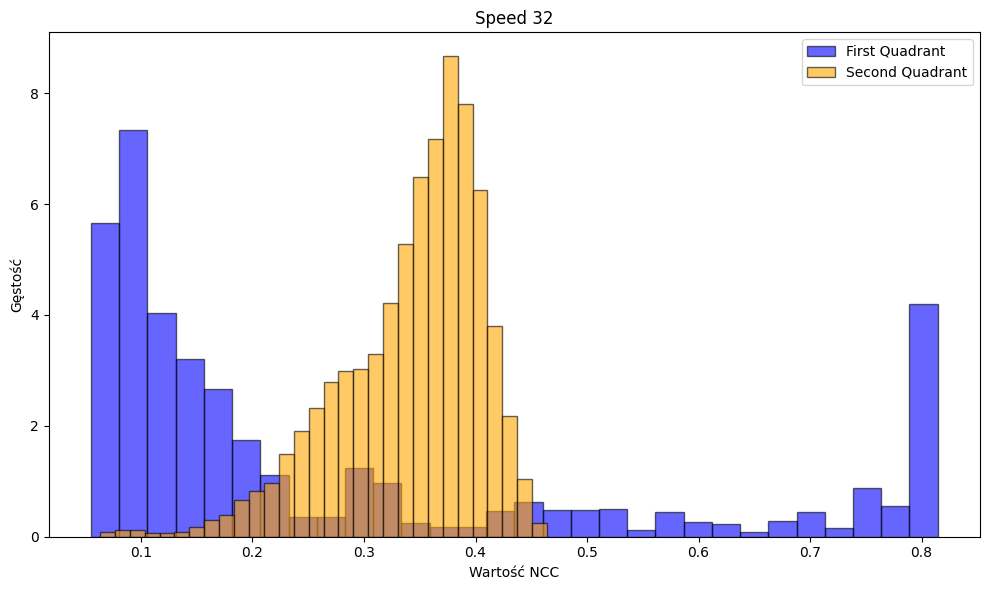

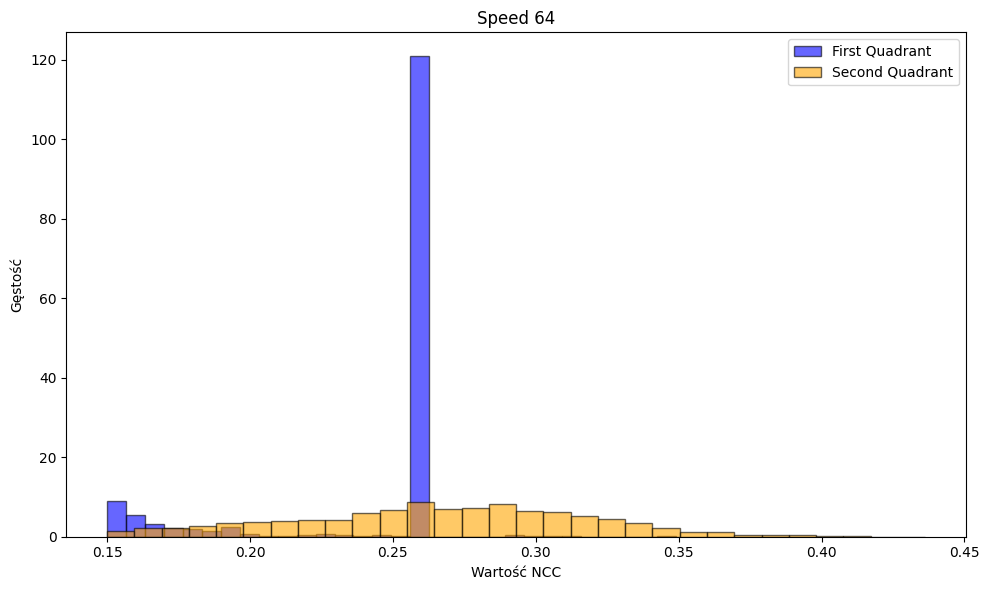

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def clean_ncc_values(ncc_values):
    """Replace extreme outliers and ensure values stay within the range [-1, 1]."""
    valid_mean = np.mean(ncc_values[(ncc_values >= -1) & (ncc_values <= 1)])
    ncc_values = np.where(ncc_values < -1, valid_mean, ncc_values)
    ncc_values = np.where(ncc_values > 1, valid_mean, ncc_values)
    return ncc_values

def load_ncc_data(file_path):
    """Load and clean NCC values, X coordinates, and Y coordinates from the specified HDF5 file."""
    with h5py.File(file_path, 'r') as file:
        ncc_values = file['1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
        X_coords = file['1/EBSD/Data/X'][:]
        Y_coords = file['1/EBSD/Data/Y'][:]
    ncc_values = clean_ncc_values(ncc_values)
    return ncc_values, X_coords, Y_coords

def plot_histogram_without_kde(ncc_values, X_coords, Y_coords, histogram_name="Histogram"):
    """Plot a histogram without KDE lines and with a custom title."""
    first_quadrant_indices = (X_coords < X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    second_quadrant_indices = (X_coords >= X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
    first_quadrant_ncc = ncc_values[first_quadrant_indices]
    second_quadrant_ncc = ncc_values[second_quadrant_indices]
    
    plt.figure(figsize=(10, 6))
    plt.hist(first_quadrant_ncc, bins=30, alpha=0.6, label="Pierwszy kwadrant", color='blue', edgecolor='black', density=True)
    plt.hist(second_quadrant_ncc, bins=30, alpha=0.6, label="Drugi kwadrant", color='orange', edgecolor='black', density=True)
    
    plt.title(histogram_name)
    plt.xlabel("Wartość NCC")
    plt.ylabel("Gęstość")
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_histograms_without_kde(file_paths, custom_titles):
    """Generate histograms without KDE lines and with custom titles."""
    for file_path, custom_title in zip(file_paths, custom_titles):
        try:
            ncc_values, X_coords, Y_coords = load_ncc_data(file_path)
            plot_histogram_without_kde(ncc_values, X_coords, Y_coords, histogram_name=custom_title)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")


file_paths = [
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 4 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 9 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 16 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 25 frames_1quadrantprocessed.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test saturated 49 pps(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x16.h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x32(1).h5oina',
    '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 speed test speed x64.h5oina',
]

custom_titles = [
    'averaging 1 frame',
    'averaging 4 frames',
    'averaging 9 frames',
    'averaging 16 frames',
    'averaging 25 frames',
    'Speed 1',
    'Speed 16',
    'Speed 32',
    'Speed 64'
]


visualize_histograms_without_kde(file_paths, custom_titles)